# LangGraph Chain

# 1. Import Packages

In [1]:
# APIs
import os
from dotenv import load_dotenv

# Models-1
import HFModel
from langchain_openai import ChatOpenAI
from langchain_huggingface import ChatHuggingFace

# Graph
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import HumanMessage
from IPython.display import Image, display

# 2. Create Chat Models

In [2]:
load_dotenv(override=True)

# GPT
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "type-your-api-key-here")
gpt = "gpt-4o-mini"

# Ollama
OLLAMA_API_KEY = "ollama"
OLLAMA_BASE_URL = "http://localhost:11434/v1"
llama = "llama3.2"

# Hugging Face-1
HF_TOKEN = os.getenv("HUGGINGFACE_TOKEN", "type-your-token-here")
hf_model_name = "meta-llama/Llama-3.2-1B-Instruct"
llama_hf = HFModel.HFModel(hf_token=HF_TOKEN, model_name=hf_model_name, temperature=0.3)

# Note: The Llama 3.2 1B model has LIMITED tool calling support. better to use other models.

Successfully login to Hugging Face.
Tokenizer for meta-llama/Llama-3.2-1B-Instruct is loaded.
The quantization config is created.


Device set to use cuda:0


Model meta-llama/Llama-3.2-1B-Instruct is loaded.
The text generation pipeline is created.
The Hugging Face pipeline is created.


In [3]:
llama_hf.get_model_info()

{'model_name': 'meta-llama/Llama-3.2-1B-Instruct',
 'temperature': 0.3,
 'vocab_size': 128256,
 'max_new_tokens': 512,
 'model_size': 749275136,
 'quantized': True,
 'device': device(type='cuda', index=0)}

In [4]:
# Create chat models
llm_gpt = ChatOpenAI(model=gpt, temperature=0.3)
llm_llama = ChatOpenAI(model=llama, temperature=0.3, api_key=OLLAMA_API_KEY, base_url=OLLAMA_BASE_URL)
llm_llama_hf = ChatHuggingFace(llm=llama_hf.hf_pipeline, model_id=llama_hf.model_name)

## Testing the Chat Models

### GPT

In [5]:
%%time
test_gpt_response = llm_gpt.invoke("Hello there!")
test_gpt_response

CPU times: total: 62.5 ms
Wall time: 2.03 s


AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 10, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-Bh7hqaq6qdqD0DblZbo7kULukDVeT', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--c4f3cc54-c172-4d8e-990f-c418a2dadec3-0', usage_metadata={'input_tokens': 10, 'output_tokens': 9, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
test_gpt_response.response_metadata

{'token_usage': {'completion_tokens': 9,
  'prompt_tokens': 10,
  'total_tokens': 19,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-mini-2024-07-18',
 'system_fingerprint': 'fp_34a54ae93c',
 'id': 'chatcmpl-Bh7hqaq6qdqD0DblZbo7kULukDVeT',
 'service_tier': 'default',
 'finish_reason': 'stop',
 'logprobs': None}

### Llama Ollama

In [7]:
%%time
test_llama_response = llm_llama.invoke("Hello there!")
test_llama_response

CPU times: total: 31.2 ms
Wall time: 4.27 s


AIMessage(content="It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 28, 'total_tokens': 51, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'llama3.2', 'system_fingerprint': 'fp_ollama', 'id': 'chatcmpl-187', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--97a7ce9d-5077-4d4a-9e58-c1712fa9f1d5-0', usage_metadata={'input_tokens': 28, 'output_tokens': 23, 'total_tokens': 51, 'input_token_details': {}, 'output_token_details': {}})

In [8]:
test_llama_response.response_metadata

{'token_usage': {'completion_tokens': 23,
  'prompt_tokens': 28,
  'total_tokens': 51,
  'completion_tokens_details': None,
  'prompt_tokens_details': None},
 'model_name': 'llama3.2',
 'system_fingerprint': 'fp_ollama',
 'id': 'chatcmpl-187',
 'service_tier': None,
 'finish_reason': 'stop',
 'logprobs': None}

### Llama Hugging Face

In [9]:
%%time
test_llama_hf_response = llm_llama_hf.invoke("Hello there!")
test_llama_hf_response

CPU times: total: 1.39 s
Wall time: 1.41 s


AIMessage(content="Hello! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={}, id='run--de4c3bb7-768f-4150-b63f-4063e0037b80-0')

In [10]:
test_llama_hf_response.response_metadata

{}

# 3. Create Models with Tools

In [11]:
# Example of a tool
def multiply(a: int, b: int):
    """Multiply a and b

    Args:
        a: first int
        b: second int

    Return:
        Multiplication of a and b
    """
    return a * b

tools = [multiply]

In [12]:
# Model with tools
llm_gpt_with_tools = llm_gpt.bind_tools(tools)
llm_llama_with_tools = llm_llama.bind_tools(tools)
llm_llamahf_with_tools = llm_llama_hf.bind_tools(tools)

# 4. Build a Graph

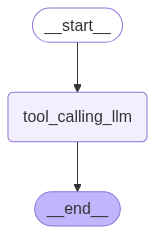

In [13]:
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_llama_with_tools.invoke(state["messages"])]} # change chat model with tools freely

builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

## Testing the Graph

In [14]:
messages = graph.invoke({"messages": HumanMessage(content="How many 5870 multipled by 5123.")})
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

How many 5870 multipled by 5123.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_osamw47d)
 Call ID: call_osamw47d
  Args:
    a: 5870
    b: 5123
